## Imports

#### **You will need to install the "haversine" and "cartopy" modules first. I recommend conda-forge

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dts
import pandas as pd
import os
import cartopy.crs as ccrs
from haversine import haversine
from operator import attrgetter
from matplotlib.lines import Line2D
from datetime import datetime, timedelta
from glob import glob

# imports from this repository
import helpers
from station import Station

## Download CWS data from Synoptic (MesoWest)

In [12]:
stations_file = './data/20191216.json' #filename for the download output. name this whatever you want, plus .json
api_token = '###############' #API token from your Synoptic account
lat = 34.582253 
lon = -86.927738
radius = 75 #range in km, from the lat/lon coordinates provided, in which to search for stations
max_stations = 100 #max number of stations to download
start_datetime = 201912160600 #date and time for start of the data
end_datetime = 201912170600

if not os.path.exists(stations_file):
    print('Starting download ...')
    Station.download(stations_file, api_token, lat, lon, radius, max_stations, start_datetime, end_datetime)
else:
    print('File already exists. Cancelling download ...')

File already exists. Cancelling download ...


## Loading the data file

In [3]:
st = Station.loadFromJSON(stations_file)

## Plotting

#### Plot all station locations and their MNET ID's

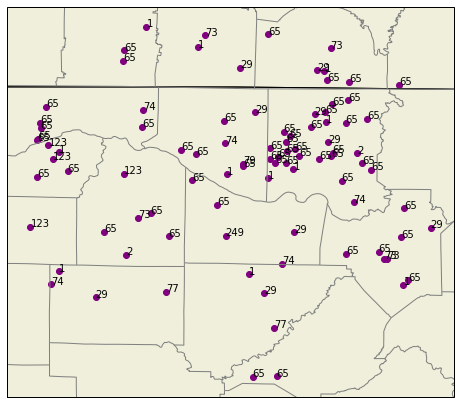

In [4]:
plt.figure(figsize=(8,8))
county_path = './counties/countyl010g.shp' #path to the county shapefile
ax = helpers.cartopyMap(county_path)

for s in st:
    ax.scatter(s.lon, s.lat, transform=ccrs.PlateCarree(), color='purple')
    plt.text(s.lon, s.lat, s.mnet)

#### Plot ASOS and CWOP station locations

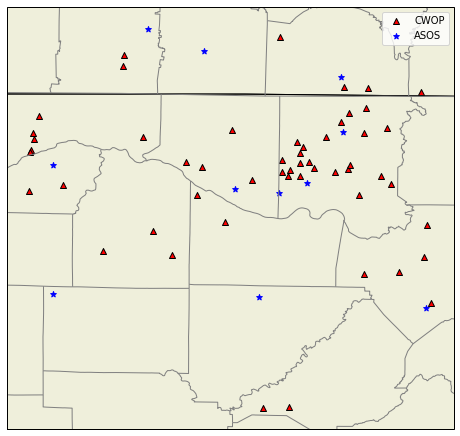

In [5]:
plt.figure(figsize=(8,8))
ax = helpers.cartopyMap(county_path)

# cwop data
cwop = [s for s in st if s.mnet == 65]
lons = [a.lon for a in cwop]
lats = [a.lat for a in cwop]
ax.scatter(lons, lats, facecolor='r', edgecolor='k', marker='^', transform=ccrs.PlateCarree(), label='CWOP')

# asos data
asos = [s for s in st if s.mnet == 1]
lons = [a.lon for a in asos]
lats = [a.lat for a in asos]
ax.scatter(lons, lats, c='b', marker='*', transform=ccrs.PlateCarree(), label='ASOS')
plt.legend()

#### Plot lines between CWOP stations and the nearest ASOS station

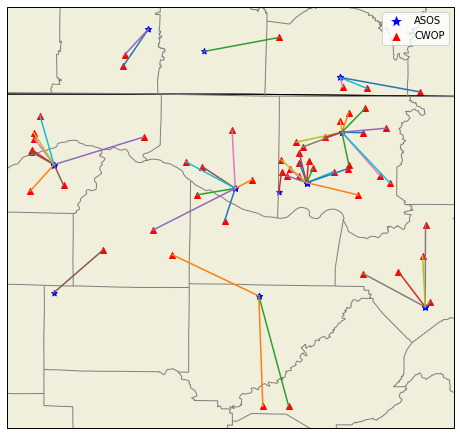

In [6]:
plt.figure(figsize=(8,8))
ax = helpers.cartopyMap(county_path)

nearest = [Station.toNearestStation(c, asos) for c in cwop]
#print([n.haversine for n in nearest])
for c in cwop:
    ax.scatter(c.lon, c.lat, marker='^', color='r')
for n in nearest:
    ax.scatter(n.lon, n.lat, marker='*', color='b')
for n in range(len(cwop)):
    ax.plot([cwop[n].lon, nearest[n].lon],[cwop[n].lat, nearest[n].lat])
legendElements = [Line2D([0], [0], marker='*', color='w', markerfacecolor='b', 
                         markersize=15, label='ASOS'),
                  Line2D([0], [0], marker='^', color='w', markerfacecolor='r', 
                         markersize=10, label='CWOP')]
ax.legend(handles=legendElements)
#plt.savefig('nearestCwopAsos_new.png', dpi=1000)

#### Plot all available temperatures

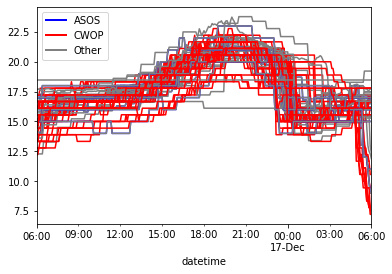

In [7]:
fig, ax = plt.subplots()

for s in st:
    if s.mnet == 1:
        Station.processTS(s, 'temp', filt='5T').plot(ax=ax, color='b')
    if s.mnet == 65:
        Station.processTS(s, 'temp', filt='5T').plot(ax=ax, color='r')
    else:
        Station.processTS(s, 'temp', filt='5T').plot(ax=ax, color='gray')
    
# create a custom legend
custom_lines = [Line2D([0], [0], color='blue', lw=2),
                Line2D([0], [0], color='red', lw=2),
                Line2D([0], [0], color='gray', lw=2)]
ax.legend(custom_lines, ['ASOS', 'CWOP', 'Other'])

#### Plot all ASOS temperature data

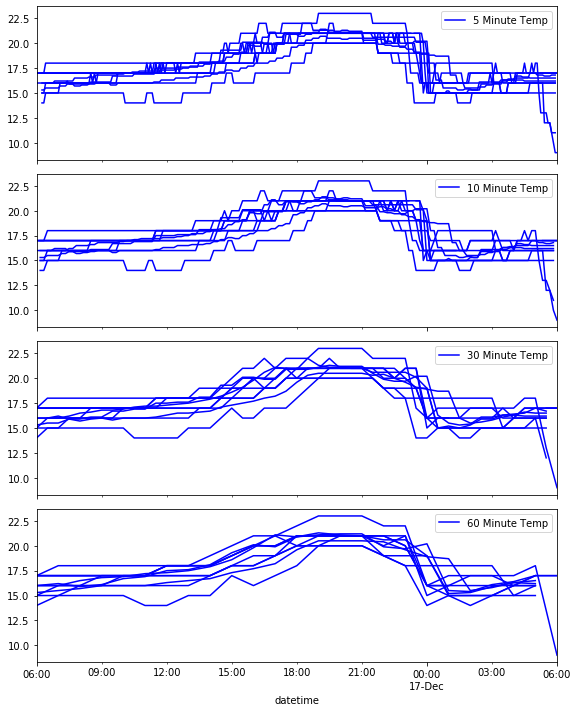

In [8]:
fig = plt.figure(figsize=(8,10))

ax = fig.add_subplot(411)
for a in asos:
    Station.processTS(a, 'temp', filt='5T').plot(ax=ax, color='b')
lines, labels = ax.get_legend_handles_labels()
labels[0] = '5 Minute Temp'
ax.legend(lines[:1], labels[:1])

ax = fig.add_subplot(412, sharex=ax)
for a in asos:
    Station.processTS(a, 'temp', filt='10T').plot(ax=ax, color='b')
labels[0] = '10 Minute Temp'
ax.legend(lines[:1], labels[:1])
    
ax = fig.add_subplot(413, sharex=ax)
for a in asos:
    Station.processTS(a, 'temp', filt='30T').plot(ax=ax, color='b')
labels[0] = '30 Minute Temp'
ax.legend(lines[:1], labels[:1])
    
ax = fig.add_subplot(414, sharex=ax)
for a in asos:
    Station.processTS(a, 'temp', filt='60T').plot(ax=ax, color='b')
labels[0] = '60 Minute Temp'
ax.legend(lines[:1], labels[:1])

plt.tight_layout()

#### Scatter and Histograms

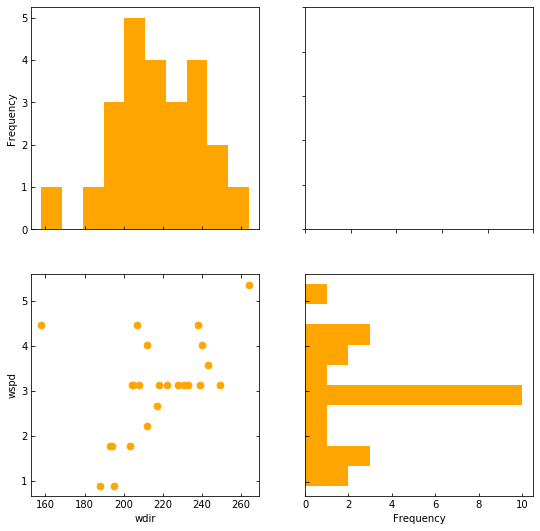

In [9]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(9,9))

df_wspd = Station.processTS(st[0], 'wspd')
df_wdir = Station.processTS(st[0], 'wdir')
df = pd.concat([df_wspd, df_wdir], axis=1)

df.plot.scatter(x='wdir', y='wspd', ax=ax[1,0], color='orange', s=45)
ax[1,0].tick_params(direction='in', top='True', right='True')

df['wspd'].plot.hist(ax=ax[1,1], color='orange', orientation='horizontal', sharey=True)
ax[1,1].tick_params(direction='in')

df['wdir'].plot.hist(ax=ax[0,0], color='orange', sharex=True)
ax[0,0].tick_params(direction='in')

#### Boxplot time series

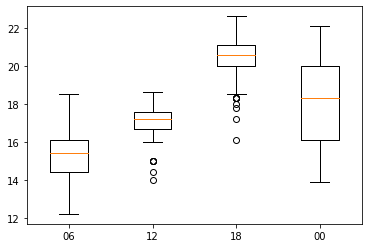

In [10]:
dfs = [Station.processTS(s, 'temp') for s in st]

temp_06 = np.array([helpers.getAtTime(d, '2019-12-16 06:00:00', 'temp') for d in dfs])
temp_06 = temp_06[~np.isnan(temp_06)]
temp_12 = np.array([helpers.getAtTime(d, '2019-12-16 12:00:00', 'temp') for d in dfs])
temp_12 = temp_12[~np.isnan(temp_12)]
temp_18 = np.array([helpers.getAtTime(d, '2019-12-16 18:00:00', 'temp') for d in dfs])
temp_18 = temp_18[~np.isnan(temp_18)]
temp_00 = np.array([helpers.getAtTime(d, '2019-12-17 00:00:00', 'temp') for d in dfs])
temp_00 = temp_00[~np.isnan(temp_00)]

boxplots = plt.boxplot([temp_06, temp_12, temp_18, temp_00], labels=['06','12','18','00'])


## Working with multiple files

#### Collect data from multiple days

In [22]:
#load all station days
paths = glob('./data/*0600.json')
allStations = [Station.loadFromJSON(p) for p in paths]

#get names of stations if those stations appear every day of the month
numdays=31
names = [[s.name for s in sts] for sts in allStations]
namesFlat = [name for namesList in names for name in namesList]
uniqueNames = pd.unique(namesFlat)
counts = [namesFlat.count(u) for u in uniqueNames]
nameLenZip = list(zip(uniqueNames, counts))
namesDays = [z[0] for z in nameLenZip if z[1] == numdays]

#get all stations that have data every day of the month
allStationsMonth = [[s for s in st if s.name in namesDays] for st in allStations]

#remove stations if they don't contain enough unique observations
#generate a list of the number of unique temp observations 
listOfUnique = []
for s in allStationsMonth[0]:
    temps = np.array(s.temp, dtype=np.float)
    numOfUnique = len(np.unique(temps[~np.isnan(temps)]))
    listOfUnique = np.append(listOfUnique, numOfUnique)
# print(listOfUnique)

#find indices where there are less than 5 unique observations
lessThan = np.where(listOfUnique < 5, False, True)
# print(lessThan)

#remove stations that have less than 5 unique observations
allStationsMonth = [list(np.array(allSt)[lessThan]) for allSt in allStationsMonth]

#find range of dates with times always 21Z
numdays = 31
time = datetime(2019,12,1,21)
dtObjs = [time + timedelta(days=d) for d in range(numdays)]
datetimes = [o.strftime('%Y-%m-%d %H:%M:%S') for o in dtObjs]

#number of stations on a day of the month
numOfStationsOneDay = range(len(allStationsMonth[0]))
#lists groups of daily station data
station = [[s[i] for s in allStationsMonth] for i in numOfStationsOneDay]

#given a list of daily station data grouped by month, concatenate daily data
#into one month for each station. Then locate values at a given time of each day.
#Take the mean of those daily values at the given time. 
avgTemps = [pd.concat([Station.processTS(s, 'temp', filt='5T') for s in st]).at_time('21:00:00').mean() for st in station]
avgPress = [pd.concat([Station.processTS(s, 'pres', filt='5T') for s in st]).at_time('21:00:00').mean() for st in station]
thetas = helpers.thetaCalc(np.array(avgTemps), np.array(avgPress))

elevs = [s[0].elev for s in station]
mnets = [s[0].mnet for s in station]
asosInd = np.array(mnets) == 1
cwopInd = np.array(mnets) == 65
otherInd = (np.array(mnets) != 1) & (np.array(mnets) != 65)

#### Plotting

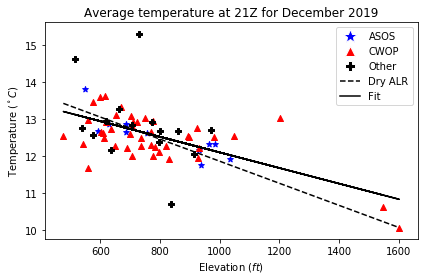

In [23]:
fig, ax = plt.subplots()

plottingVar = avgTemps
ax.scatter(np.array(elevs)[asosInd], np.array(plottingVar)[asosInd], color='b', marker='*')
ax.scatter(np.array(elevs)[cwopInd], np.array(plottingVar)[cwopInd], color='r', marker='^')
ax.scatter(np.array(elevs)[otherInd], np.array(plottingVar)[otherInd], color='k', marker='P')

#plot a best fit line through the data
m, b = np.polyfit(elevs,avgTemps,1)
plt.plot(elevs, m*np.array(elevs) + b, 'k-')

#plot dry adiabatic lapse rate
dryALRhgts = np.arange(np.min(elevs), np.max(elevs), 2)
plt.plot(dryALRhgts, helpers.dryALR(dryALRhgts), 'k--')

#legend
legendElements = [Line2D([0], [0], marker='*', color='w', markerfacecolor='b', 
                 markersize=15, label='ASOS'),
                  Line2D([0], [0], marker='^', color='w', markerfacecolor='r',
                         markersize=10, label='CWOP'),
                 Line2D([0], [0], marker='P', color='w', markerfacecolor='k',
                 markersize=10, label='Other'),
                Line2D([0],[0], linestyle='--', color='k', label='Dry ALR'),
                Line2D([0],[0], linestyle='-', color='k', label='Fit')]
ax.legend(handles=legendElements)
plt.title('Average temperature at ' + str(time.hour) + 'Z for ' 
          + str(time.strftime('%B %Y')))
plt.ylabel('Temperature ($^\circ C$)') #temperature
plt.xlabel('Elevation $(ft)$')
plt.tight_layout()
#plt.savefig('monthTempDecember21Z.png', dpi=1000)

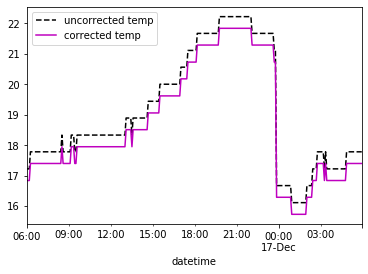

In [49]:
#value differences between average temps and the dry ALR model
errors = np.array(avgTemps) - helpers.dryALR(np.array(elevs))

#store errors from dry ALR model in each station as a new attribute
stations = [s[0] for s in station]
for i in range(len(station)): #len 69
    setattr(stations[i], 'error', errors[i])

#load data from a random day, maintaining stored errors
st1 = Station.loadFromJSON('./data/20191216.json')
stationNames = [s.name for s in stations]
st1 = [s for s in st1 if s.name in stationNames]
for i in range(len(st1)): #inherit error attribute if station names match 
    for s in stations:
        if st1[i].name == s.name:
            setattr(st1[i], 'error', s.error)
        else:
            continue
    
#correct data from a random day with stored errors
decatur = Station.processTS(st1[0], 'temp', filt='5T')
decaturCorr = decatur - st1[0].error[0]

#change column labels
decatur.columns = ['uncorrected temp']
decaturCorr.columns = ['corrected temp']

#plot corrected data
fig, ax = plt.subplots()
decatur.plot(style='k--', ax=ax)
decaturCorr.plot(style='m', ax=ax)

#### Correct data from a station

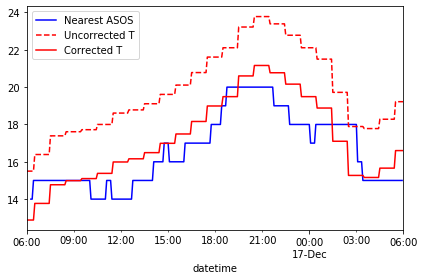

In [11]:
other = [s for s in st if s.name == 'HODGES']
nearest = [Station.toNearestStation(o, asos) for o in other]
fig, ax = plt.subplots()
Station.processTS(nearest[0], 'temp', filt='5T').plot(ax=ax, color='b')
Station.processTS(other[0], 'temp', filt='5T').plot(ax=ax, color='r', linestyle='--')
hodges = Station.processTS(other[0], 'temp', filt='5T') - 2.62 #estimated bias of 2.62
hodges.plot(ax=ax, color='r')

lines, labels = ax.get_legend_handles_labels()
labels = ['Nearest ASOS', 'Uncorrected T', 'Corrected T']
ax.legend(lines, labels)

plt.tight_layout()
#plt.savefig('hodgesErrorCorrected.png', dpi=1000)

#### Potential temperature analysis

(11,)
(11, 69)


ValueError: x and y must be the same size

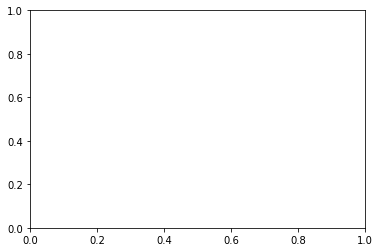

In [63]:
#find thetas with hypsometric equation
elevs = [s[0].elev for s in station]
press = helpers.hypsometric(np.array(avgTemps), np.array(elevs)) 
thetas = helpers.thetaCalc(np.array(avgTemps), press)

#plot data
plottingVar = thetas
fig, ax = plt.subplots()
print(np.array(elevs)[asosInd].shape)
print(np.array(plottingVar)[asosInd].shape)
ax.scatter(np.array(elevs)[asosInd], np.array(plottingVar)[asosInd], color='b', marker='*')
ax.scatter(np.array(elevs)[cwopInd], np.array(plottingVar)[cwopInd], color='r', marker='^')
ax.scatter(np.array(elevs)[otherInd], np.array(plottingVar)[otherInd], color='k', marker='P')

#linear fit through data
m, b = np.polyfit(elevs,thetas,1)
plt.plot(elevs, m*np.array(elevs) + b, 'k-')

#dry ALR through average of data at 700 ft
dryALRhgts = np.arange(np.min(elevs), np.max(elevs), 2)
plt.plot([np.min(elevs), np.max(elevs)], [14.75, 14.75], 'k--')

#legend
legendElements = [Line2D([0], [0], marker='*', color='w', markerfacecolor='b', 
                 markersize=15, label='ASOS'),
                  Line2D([0], [0], marker='^', color='w', markerfacecolor='r',
                         markersize=10, label='CWOP'),
                 Line2D([0], [0], marker='P', color='w', markerfacecolor='k',
                 markersize=10, label='Other'),
                Line2D([0],[0], linestyle='--', color='k', label='Dry ALR'),
                Line2D([0],[0], linestyle='-', color='k', label='Fit')]
ax.legend(handles=legendElements)

#title, axes labels
plt.title('Average $\Theta$ at ' + str(time.hour) + 'Z for ' 
          + str(time.strftime('%B %Y')))
plt.ylabel('Potential temperature, $\Theta$ ($^\circ C$)') #temperature
plt.xlabel('Elevation $(ft)$')
plt.tight_layout()